In [2]:
import numpy as np
import math as math
import cmath as cmath
import psutil as psutil
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import gridspec as gridspec
import argparse as argparse
import operator as operator
import warnings as warnings
import copy as copy
import time as time
import pdb
import os as os
import random
import k2
import libcarma as libcarma
import util.mcmcviz as mcmcviz
import s82
from util.mpl_settings import set_plot_params
import util.triangle as triangle
import cPickle as pickle
%matplotlib inline

/Users/Jackster/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Jackster/Research/code/libcarma/python/s82.py:39: UserWarning: carma_pack not found. Not using carma_pack!!
  warnings.warn('carma_pack not found. Not using carma_pack!!')


# Combining SDSS and K2 Lightcurves

In [4]:
#Loading SDSS g and r band flux lightcurves: object #1
sdsslc_r = s82.sdssLC(name = '005102.42-010244.4', band = 'r')
sdsslc_g = s82.sdssLC(name = '005102.42-010244.4', band = 'g')
sdsslc_r2 = s82.sdssLC(name = '005232.43+005123.0', band = 'r')
sdsslc_g2 = s82.sdssLC(name = '005232.43+005123.0', band = 'g')

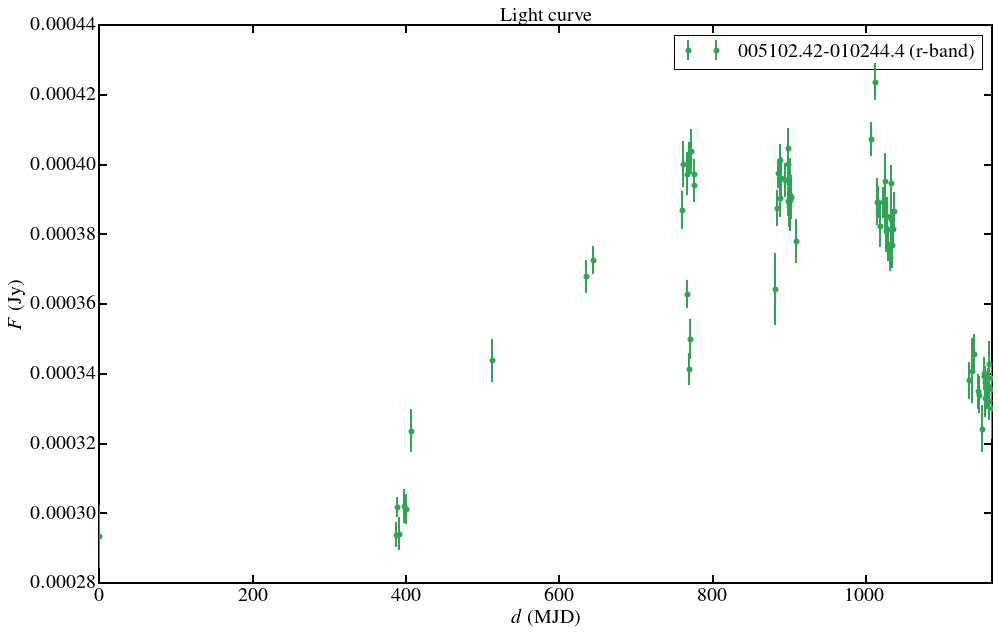

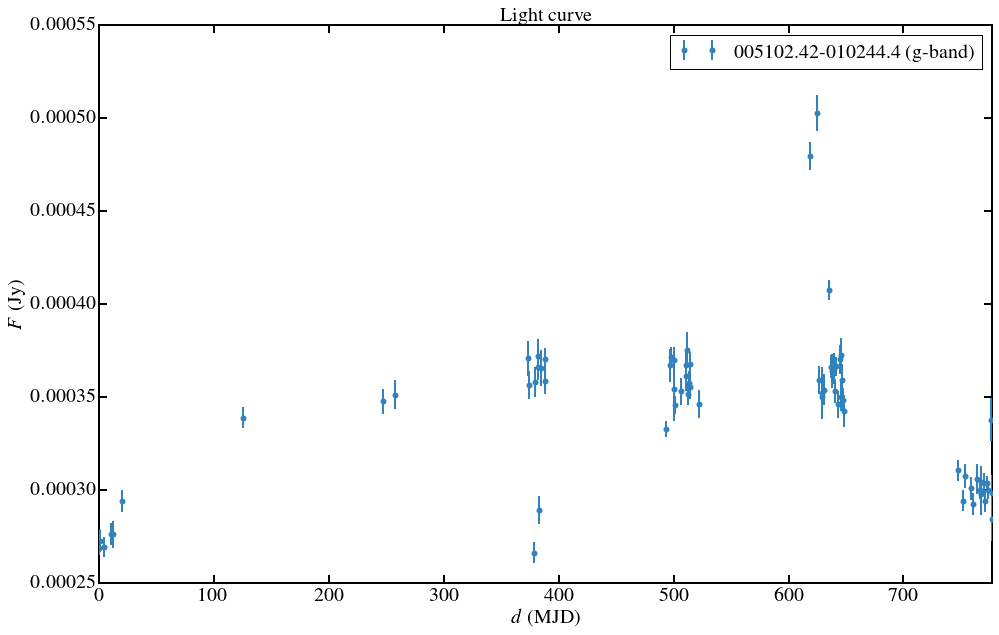

In [8]:
#plot lightcurves for band r and g
a = sdsslc_r.plot(1)
b = sdsslc_g.plot(2)



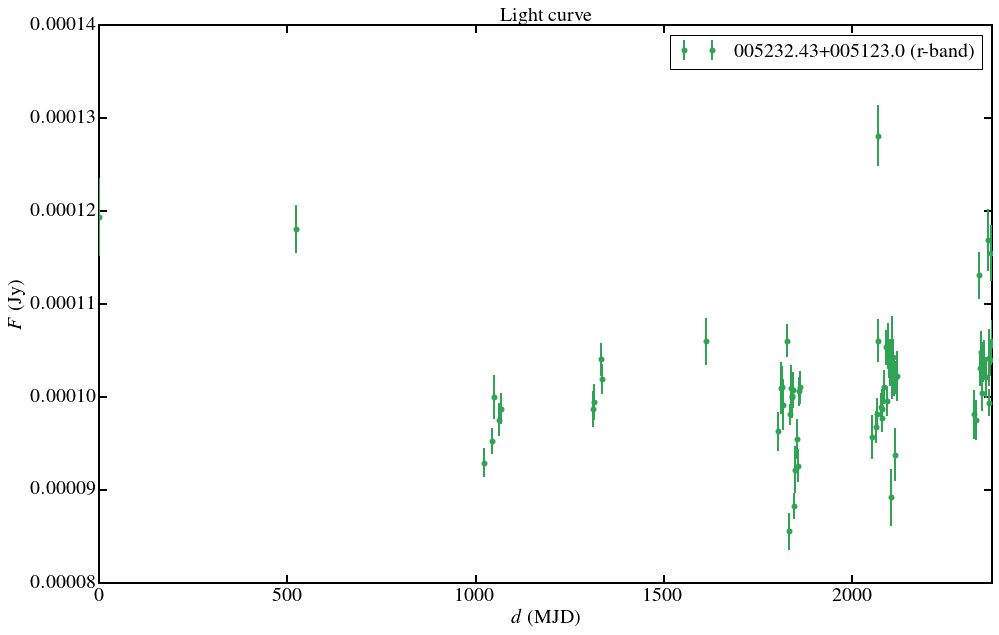

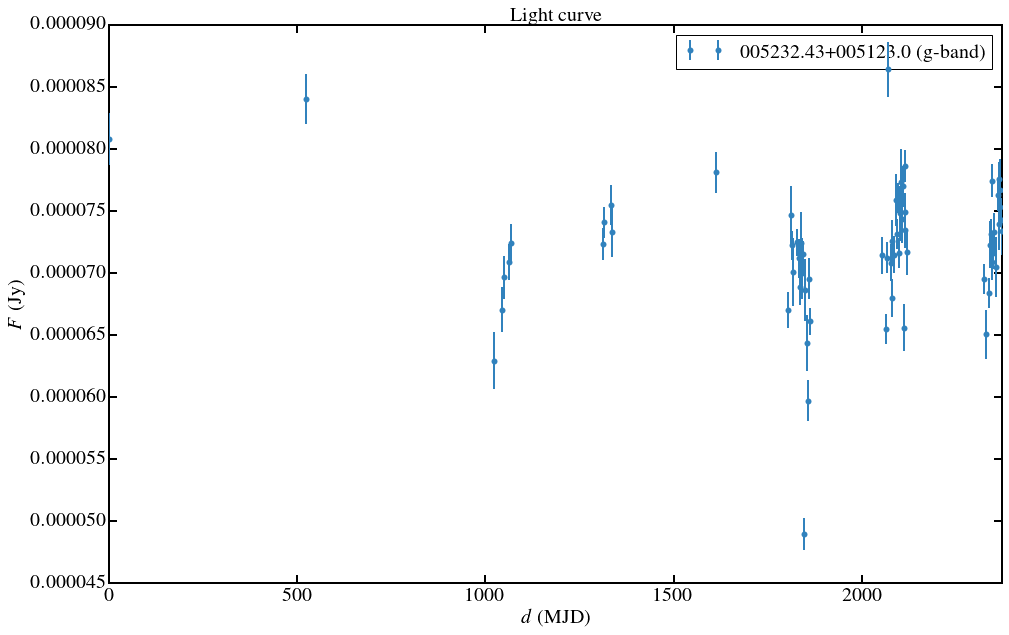

In [9]:
c = sdsslc_r2.plot(1)
d = sdsslc_g2.plot(2)

(array([], dtype=float64), array([], dtype=float64))


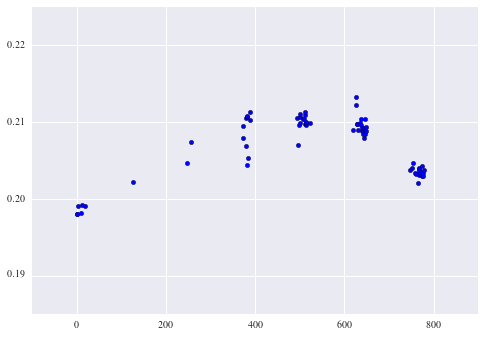

In [70]:
# make new kepler flux
def kepFlux(sdsslc_r,sdsslc_g):
    sdss_g = sdsslc_g.y
    sdss_r = sdsslc_r.y
    sdss_t = sdsslc_g.t
    
    if len(sdss_r) != len(sdss_g):
        print sdsslc_r.t[-1], sdsslc_g.t[-1]
        #catch missing g band measurements in the middle of the array 
        for i in range(0, len(sdss_t)):
            tolerance = 0.0002
            missed = np.isclose(sdsslc_r.t, sdss_t[i],tolerance)
            m = np.where(missed == True)[0]
            #print m, i
            if m != i:
                print m, i, len(sdss_t)
                sdss_g = np.insert(sdss_g, m ,0.)
                sdss_t = np.insert(sdss_t, m ,sdsslc_r.t[m])
                print sdss_g[m], sdss_t[i], len(sdss_t),len(sdsslc_r.t)
            if len(sdss_r) == len(sdss_g):
                break
    c = pow(sdss_r, 0.2) + pow(sdss_g,0.8)
    fullr = np.where(sdss_g == 0.)[0]
    c[fullr] = sdss_r[fullr]
    print(c[fullr],sdss_r[fullr-1])
    #c_err = pow(sdsslc_r.yerr, 0.2) + pow(sdsslc_g.yerr,0.8)
    c_t = sdss_t
    #return 0,0,0                   
    return c, c_err, c_t



import seaborn as sns
c, c_err, c_t = kepFlux(sdsslc_r,sdsslc_g)
plt.scatter(c_t, c)
#plt.errorbar(sdsslc_r.t, c, yerr = c_err)


2373.19856595 2373.19856595
[34] 33 67
[ 0.] 2077.93525486 68 68
(array([  9.89465435e-05]), array([ 0.00012813]))


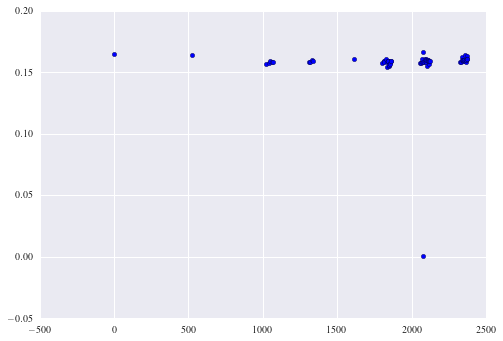

In [71]:
c2, c_err2, c_t2 = kepFlux(sdsslc_r2,sdsslc_g2)
#plt.errorbar(sdsslc_r.t, c, yerr = c_err)

plt.scatter(c_t2, c2)

# looks like the r band measurement corresponding to the missing g band observation is an outlier and should just be tossed



('the average flux is %d', 0.41072368851570423)


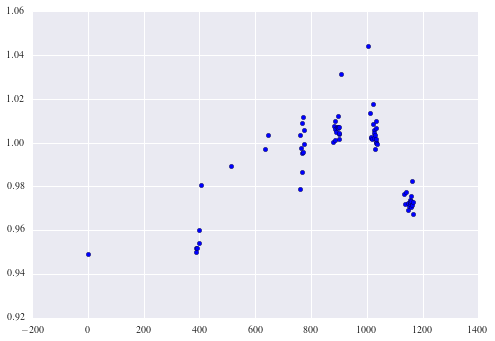

In [45]:
#sanity check: Is the lightcurve normalized? Answer : no
c_med = np.median(c)
c_norm = c/c_med
print("the average flux is %d",c_med)
plt.scatter(sdsslc_r.t, c_norm)

Median normalizing changes the shape somewhat. It appears less smooth.

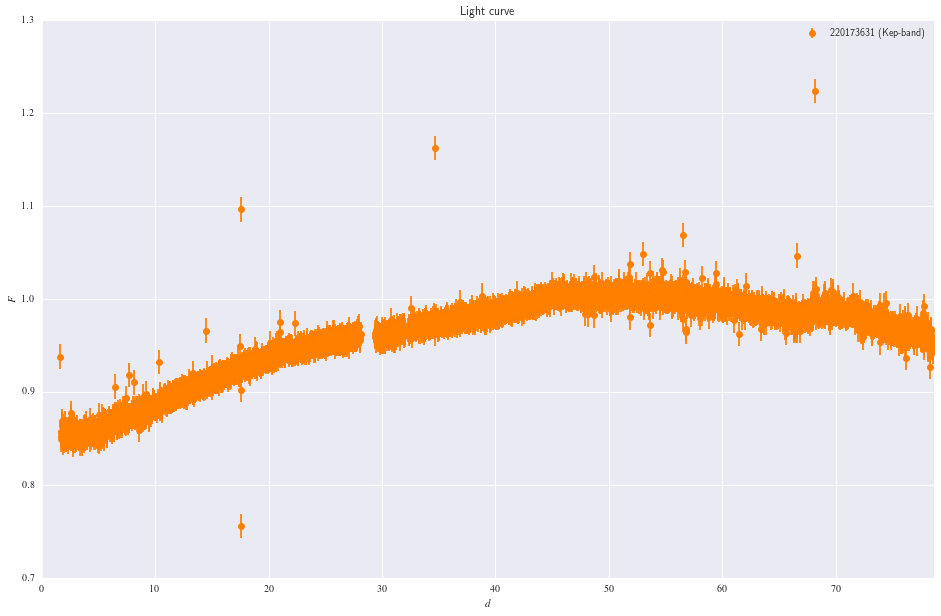

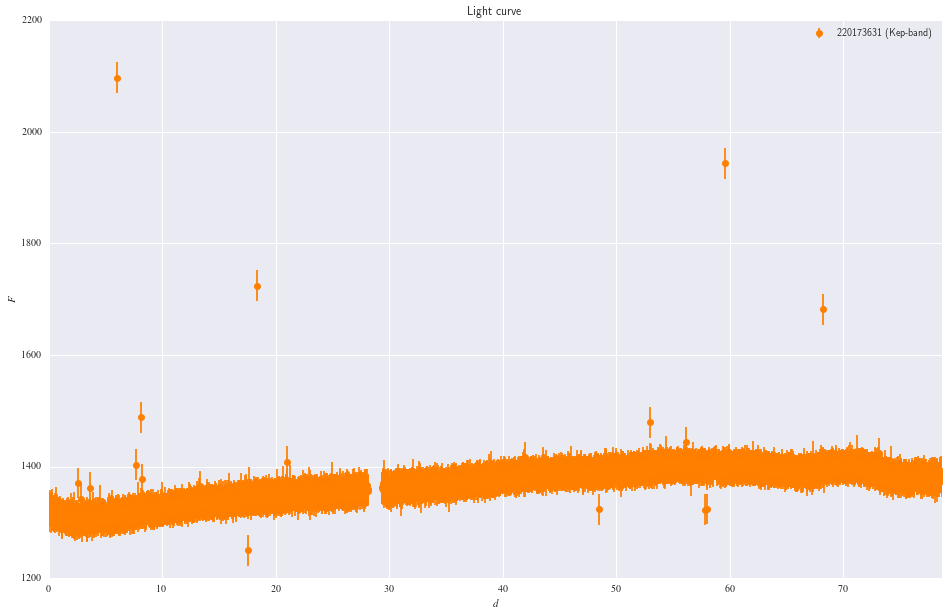

In [20]:
#load k2 lighturve for the same QSO (the first one)
k2lc = k2.k2LC(name = '220173631', band = 'Kep', processing = 'k2sff', campaign = 'c08')
everLC = k2.k2LC(name = '220173631', band = 'Kep', processing = 'everest', campaign = 'c08')
k2plot = k2lc.plot(1)
everplot = everLC.plot(2)

looks like the the everest reprocessing preserves more outliers, lets try zooming into the plot. 

In [32]:
everFlux = everLC.y/np.median(everLC.y)
w = np.where(everLC.mask==1)[0]
everF = everFlux[w]
std = np.std(everF)
std
#ww = np.where((everF[:] < 3.*std) and (everF[:] > -3.*std))[0]
#plt.scatter(everF.t[ww], everF[ww])

0.02524873139353373

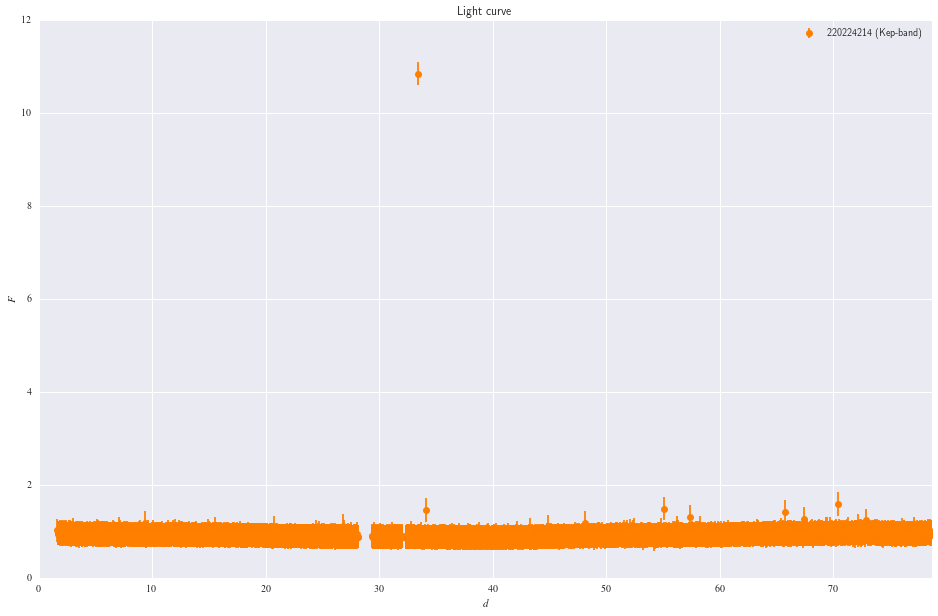

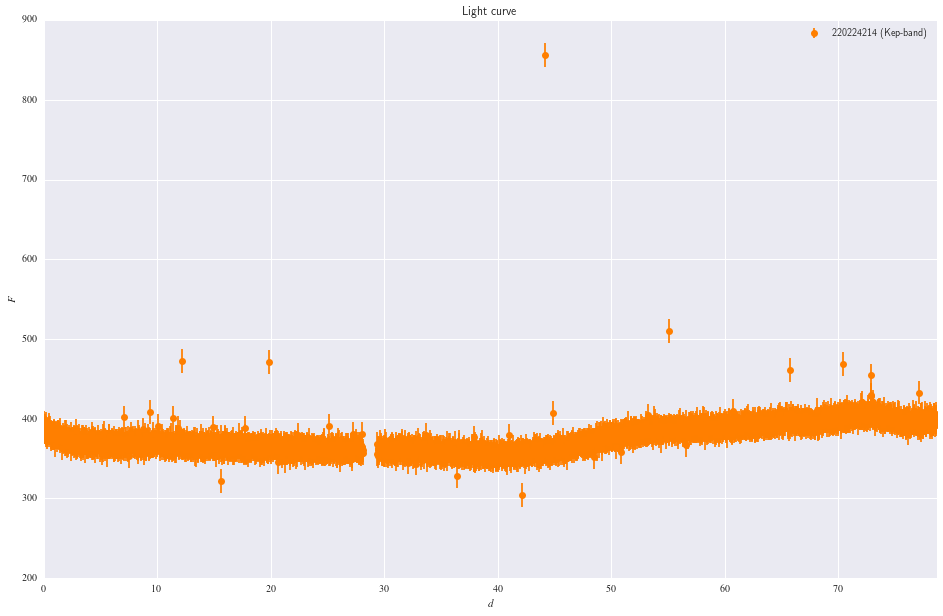

In [80]:
#220224214
k2lc2 = k2.k2LC(name = '220224214', band = 'Kep', processing = 'k2sff', campaign = 'c08')
everLC2 = k2.k2LC(name = '220224214', band = 'Kep', processing = 'everest', campaign = 'c08')
k2plot2 = k2lc2.plot(1)
#k2plot2.set_ylim([0,2])
everplot2 = everLC2.plot(2)

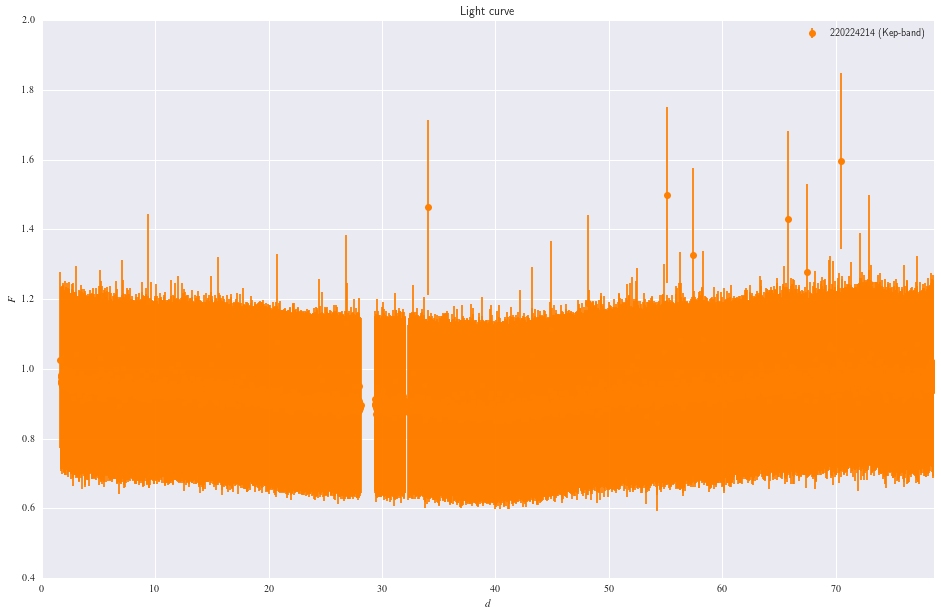

In [81]:
#write a function to remove crazy outliers
maxF = np.argmax(k2lc2.y)
k2lc2.mask[maxF] = 0
omg = k2lc2.plot(1)

# Plotting Combined lightcurve

[   0.          387.43419041  387.77977762 ...,   78.66204641   78.68247839
   78.70291026]


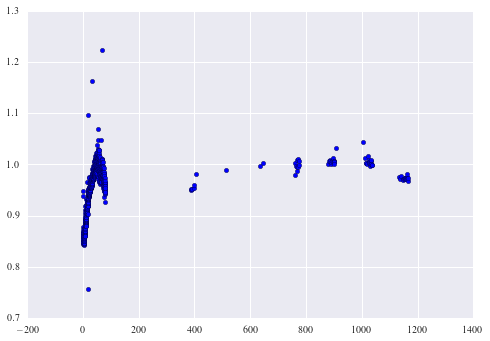

In [43]:

full_lcy = np.concatenate([c_norm, np.array(k2lc.y)])
full_lct = np.concatenate([c_t, np.array(k2lc.t)])
w = np.where(full_lcy > 0)[0]
plt.scatter(full_lct[w], full_lcy[w])
print full_lct
# t is rest to days starting from t = 0, calculate the number of days and add offset to k2 
#something appears to be wrong with the time grid for sdss

(70, 3853, 3923)
[    0.           387.43419041   387.77977762 ...,  3388.66204641
  3388.68247839  3388.70291026]


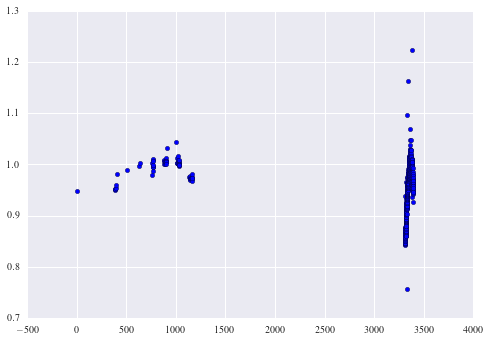

In [59]:
#compare time attibutes in sdss and k2 objects from kali
print(len(sdsslc_g.t), len(k2lc.t),len(full_lct))
k2t = k2lc.t + 3310.
full_lct = np.concatenate([c_t, k2t])
w = np.where(full_lcy > 0)[0]
plt.scatter(full_lct[w], full_lcy[w])
print full_lct
#import pandas as p
#d = {'sdss': sdsslc_g.t, 'k2': k2lc.t,'combo': full_lct}
#df = p.DataFrame(data=d, index = np.arange(len(full_lct)))


